In [5]:
import pandas as pd
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [6]:
import pickle
from pprint import pprint
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve 

In [7]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


''

In [8]:
location = "/content/gdrive/My Drive/Colab Notebooks/MultiModal_PD/"

In [9]:
df = pd.read_csv(location + "snp_masterDB.csv", sep=",")
df.head(5)

,PATNO,chr1_205739192_T_C,chr4_90753960_C_T,chr4_90756421_G_C,chr4_90760221_A_C,chr4_90760828_C_T,chr12_40761931_A_C,chr16_29826538_T_C,chr1_17313454_G_A,chr1_17314702_C_T,chr1_20977221_A_T,chr1_20977365_C_G,chr1_20977449_G_T,chr1_20978058_G_A,chr1_151668982_G_T,chr1_155829360_C_A,chr1_155837865_G_C,chr1_155838267_T_C,chr1_155852123_C_T,chr1_156040310_A_G,chr1_165171677_T_C,chr1_165171712_G_A,chr1_165172158_T_A,chr1_165173216_A_G,chr1_165218679_C_T,chr1_205737450_T_C,chr1_205737956_G_C,chr1_205738166_T_C,chr1_205738251_C_A,chr1_205738843_C_T,chr1_205739200_C_T,chr1_205744546_C_A,chr1_205797413_G_T,chr1_205801872_A_G,chr1_205810947_C_T,chr1_205812912_A_G,chr1_205814497_T_C,chr1_205814695_A_G,chr1_205819104_G_A,chr1_227071525_C_T,...,chr1_165171518_C_T,chr1_165172178_A_G,chr1_205738081_C_T,chr1_205797303_C_T,chr1_205801877_C_T,chr4_90648592_C_T,chr4_90663574_G_T,chr9_27548405_C_T,chr9_35059509_C_T,chr12_123338759_G_A,chr12_123344630_G_A,chr12_123346710_C_T,chr12_123347393_C_A,chr14_55310058_C_T,chr20_57016170_A_G,chr20_57020907_G_A,chrX_40450602_G_A,chrX_40465004_T_C,chr1_151670707_C_T,chr4_90656902_C_T,chr8_126095526_T_C,chr17_44102710_G_A,chr5_1443136_A_G,chr6_109003148_G_A,chr9_136509351_C_T,chr11_65620837_G_C,chr11_77926436_C_T,chr11_77928302_T_C,chr11_77929260_T_C,chr11_77929621_G_T,chr11_77936215_C_T,chr12_40643656_C_T,chr12_40681396_A_T,chr14_35031485_G_A,chr15_64418409_G_A,chrX_119603162_C_A,chr1_180944619_A_G,chr3_113850098_C_T,chr8_126094065_C_T,STATUS
0,3627,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3214,1,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3367,1,1,1,1,1,0,1,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Using only selected 335 features stored in this file**

---



In [10]:
file = open(location + "fea_selected.txt", "r")
retain_list = []
counter = 0
for line in file:
  counter +=1
  if(counter > 0):
    retain_list.append(line[:-1])

print(len(retain_list))

335


In [11]:
all_columns = df.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS"):
    drop_list.append(i)

df = df.drop(columns = drop_list, axis = 1)
df.head()

,chr4_90753960_C_T,chr4_90760221_A_C,chr4_90760828_C_T,chr1_20977221_A_T,chr1_20977365_C_G,chr1_20977449_G_T,chr1_20978058_G_A,chr4_90635407_C_T,chr4_90635453_A_T,chr4_90636193_T_C,chr4_90636708_T_C,chr4_90636803_G_T,chr4_90637010_A_G,chr4_90637601_G_A,chr4_90641340_T_C,chr4_90642464_A_T,chr4_90643123_C_T,chr4_90643144_C_T,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90657186_C_T,chr4_90663542_T_C,chr4_90666041_C_T,chr4_90666291_G_A,chr4_90668419_C_A,chr4_90668614_T_C,chr4_90671069_A_G,chr4_90671670_A_T,chr4_90674431_G_A,chr4_90678541_G_A,chr4_90678798_G_A,chr4_90682327_G_A,chr4_90682571_A_G,chr4_90683168_T_C,chr4_90687927_G_A,chr4_90691132_T_C,chr4_90692468_T_C,chr4_90696827_A_C,chr4_90703233_A_G,...,chr4_90657491_C_T,chr4_90663670_T_G,chr4_90664794_C_T,chr4_90668019_A_G,chr4_90671487_G_A,chr4_90671549_A_G,chr4_90672078_A_G,chr4_90673841_A_G,chr4_90674451_T_C,chr4_90675238_A_G,chr4_90677243_G_A,chr4_90682474_T_C,chr4_90683990_T_C,chr4_90686742_A_G,chr4_90687862_G_A,chr4_90690329_C_T,chr4_90690832_A_G,chr4_90690931_A_G,chr4_90694587_T_G,chr4_90695508_G_A,chr4_90696036_T_C,chr4_90719196_A_T,chr4_90721880_T_C,chr4_90726022_T_G,chr4_90726089_C_A,chr4_90734535_T_G,chr4_90737879_G_C,chr4_90742692_A_G,chr4_90742815_G_A,chr4_90742861_T_G,chr4_90744216_G_A,chr4_90702146_G_A,chr4_90752205_T_C,chr9_35060934_G_C,chr6_109004379_C_T,chr17_44051846_A_G,chr4_90758389_G_C,chr17_44039691_A_G,chr10_47915898_A_G,STATUS
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


**Futher Shuffling**

---



In [12]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,chr4_90753960_C_T,chr4_90760221_A_C,chr4_90760828_C_T,chr1_20977221_A_T,chr1_20977365_C_G,chr1_20977449_G_T,chr1_20978058_G_A,chr4_90635407_C_T,chr4_90635453_A_T,chr4_90636193_T_C,chr4_90636708_T_C,chr4_90636803_G_T,chr4_90637010_A_G,chr4_90637601_G_A,chr4_90641340_T_C,chr4_90642464_A_T,chr4_90643123_C_T,chr4_90643144_C_T,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90657186_C_T,chr4_90663542_T_C,chr4_90666041_C_T,chr4_90666291_G_A,chr4_90668419_C_A,chr4_90668614_T_C,chr4_90671069_A_G,chr4_90671670_A_T,chr4_90674431_G_A,chr4_90678541_G_A,chr4_90678798_G_A,chr4_90682327_G_A,chr4_90682571_A_G,chr4_90683168_T_C,chr4_90687927_G_A,chr4_90691132_T_C,chr4_90692468_T_C,chr4_90696827_A_C,chr4_90703233_A_G,...,chr4_90657491_C_T,chr4_90663670_T_G,chr4_90664794_C_T,chr4_90668019_A_G,chr4_90671487_G_A,chr4_90671549_A_G,chr4_90672078_A_G,chr4_90673841_A_G,chr4_90674451_T_C,chr4_90675238_A_G,chr4_90677243_G_A,chr4_90682474_T_C,chr4_90683990_T_C,chr4_90686742_A_G,chr4_90687862_G_A,chr4_90690329_C_T,chr4_90690832_A_G,chr4_90690931_A_G,chr4_90694587_T_G,chr4_90695508_G_A,chr4_90696036_T_C,chr4_90719196_A_T,chr4_90721880_T_C,chr4_90726022_T_G,chr4_90726089_C_A,chr4_90734535_T_G,chr4_90737879_G_C,chr4_90742692_A_G,chr4_90742815_G_A,chr4_90742861_T_G,chr4_90744216_G_A,chr4_90702146_G_A,chr4_90752205_T_C,chr9_35060934_G_C,chr6_109004379_C_T,chr17_44051846_A_G,chr4_90758389_G_C,chr17_44039691_A_G,chr10_47915898_A_G,STATUS
0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0,1
3,0,0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1
4,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [13]:
print(len(df))
print(len(df.columns))
print(df.columns)

input_columns = len(df.columns)-1
output_columns = 1

733
336
Index(['chr4_90753960_C_T', 'chr4_90760221_A_C', 'chr4_90760828_C_T',
       'chr1_20977221_A_T', 'chr1_20977365_C_G', 'chr1_20977449_G_T',
       'chr1_20978058_G_A', 'chr4_90635407_C_T', 'chr4_90635453_A_T',
       'chr4_90636193_T_C',
       ...
       'chr4_90744216_G_A', 'chr4_90702146_G_A', 'chr4_90752205_T_C',
       'chr9_35060934_G_C', 'chr6_109004379_C_T', 'chr17_44051846_A_G',
       'chr4_90758389_G_C', 'chr17_44039691_A_G', 'chr10_47915898_A_G',
       'STATUS'],
      dtype='object', length=336)


In [14]:
X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

# **Feature Selection from the selected 335 SNPs**

---

## **XGBoost**

---

93
chr4_90721637_C_G     0.000908
chr1_20978024_C_A     0.001004
chr4_90742861_T_G     0.001792
chr4_90736006_A_C     0.002021
chr6_109004379_C_T    0.002554
                        ...   
chr4_90741773_A_G     0.024763
chr4_90711770_T_C     0.026110
chr4_90753960_C_T     0.027876
chr4_90697979_T_C     0.032293
chr4_90678541_G_A     0.034890
Length: 93, dtype: float32


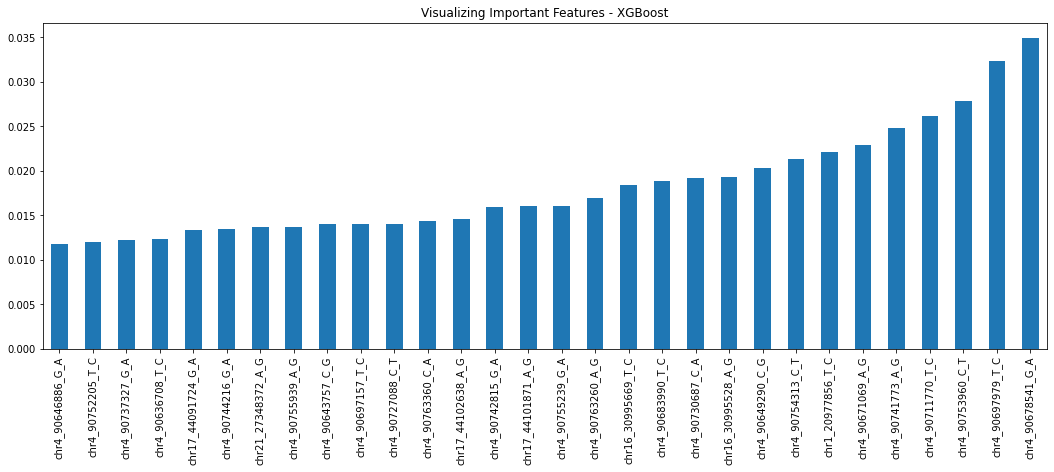

In [16]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [19]:
feaSel_XGB_desc93 = list(feature_imp[feature_imp>0].sort_values(ascending=False).index)

file = location + "feaSel_xgb_Genetic_93desc.txt"
with open(file, 'w') as file:
        for row in feaSel_XGB_desc93:
            s = "".join(map(str, row))
            file.write(s+'\n')

In [ ]:
file = location + "feaSel_xgb_Genetic.txt"
with open(file, 'w') as file:
        for row in feaSel_xgb:
            s = "".join(map(str, row))
            file.write(s+'\n')

## **LASSO Regression**

30
chr4_90741519_G_A      1.101233
chr4_90641340_T_C      0.843586
chr4_90695508_G_A      0.825161
chr12_105504953_T_C    0.773237
chr4_90742861_T_G      0.570691
chr4_90690939_G_T      0.530974
chr4_90764310_T_C      0.505997
chr4_90678541_G_A      0.461556
chr16_30995669_T_C     0.458667
chr4_90727218_A_G      0.446230
chr1_20972111_G_A      0.425257
chr4_90764188_G_A      0.424822
chr4_90682571_A_G      0.410536
chr1_20977221_A_T      0.341033
chr17_44051846_A_G     0.333259
chr1_20977000_A_C      0.330687
chr4_90754292_T_C      0.326633
chr5_122111005_G_T     0.296924
chr4_90707947_T_C      0.266676
chr1_20977449_G_T      0.256649
chr4_90703753_T_C      0.227559
chr4_90736517_T_C      0.147928
chr1_20977365_C_G      0.120000
chr1_20977599_C_G      0.103472
chr4_90763360_C_A      0.092853
chr1_20977856_T_C      0.090699
chr6_109004379_C_T     0.075668
chr4_90738148_T_A      0.021806
chr17_44073889_A_G     0.018666
chr17_44105395_A_G     0.004217
dtype: float64


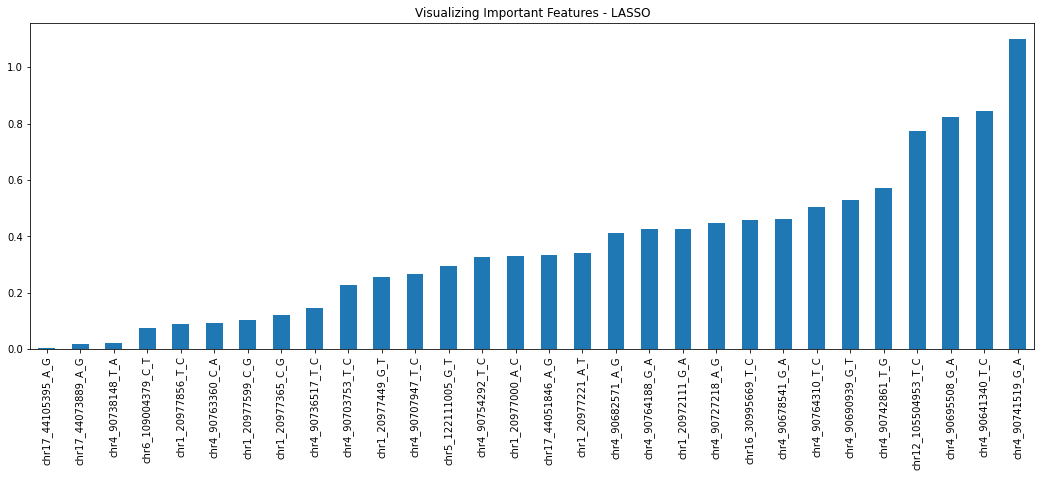

In [ ]:
lasso_clf = LogisticRegression(C=1, penalty='l1', solver='liblinear')
lasso_clf.fit(X, y)

feature_imp = pd.Series(lasso_clf.coef_[0], index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

feature_imp.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - LASSO")
plt.show()

feaSel_lasso = list(feature_imp[feature_imp>0].index)

In [ ]:
file = location + "feaSel_lasso.txt"
with open(file, 'w') as file:
        for row in feaSel_lasso:
            s = "".join(map(str, row))
            file.write(s+'\n')

## **Comparision of Features Selected by XGBoost and LASSO**

In [ ]:
set1 = set(feaSel_xgb[:30])
set2 = set(feaSel_lasso)

print(len(list(set1 & set2)))
list(set1 & set2)

4


['chr16_30995669_T_C',
 'chr4_90678541_G_A',
 'chr1_20977856_T_C',
 'chr4_90763360_C_A']

In [ ]:
# Retain only XGBoost Features
retain_list = list(feaSel_xgb)

all_columns = df.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS"):
    drop_list.append(i)

df = df.drop(columns = drop_list, axis = 1)
df.head()

,chr4_90753960_C_T,chr1_20977449_G_T,chr1_20978058_G_A,chr4_90636708_T_C,chr4_90637010_A_G,chr4_90637601_G_A,chr4_90641340_T_C,chr4_90642464_A_T,chr4_90643757_C_G,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90668419_C_A,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90682571_A_G,chr4_90703233_A_G,chr4_90707947_T_C,chr4_90709232_A_T,chr4_90711770_T_C,chr4_90721637_C_G,chr4_90727088_C_T,chr4_90730687_C_A,chr4_90736006_A_C,chr4_90736517_T_C,chr4_90737327_G_A,chr4_90739539_C_A,chr4_90741519_G_A,chr4_90741773_A_G,chr4_90743331_C_T,chr4_90748195_T_A,chr4_90754313_C_T,chr4_90755939_A_G,chr4_90757294_A_C,chr4_90757394_G_C,chr4_90759047_G_T,chr4_90760883_C_T,chr4_90763260_A_G,chr4_90763360_C_A,chr4_90765052_C_T,chr4_90767095_A_C,...,chr17_44061023_G_A,chr17_44061036_T_C,chr17_44067400_T_C,chr17_44073889_A_G,chr17_44091724_G_A,chr17_44101871_A_G,chr17_44102638_A_G,chr17_44102865_A_C,chr1_20972111_G_A,chr1_20978024_C_A,chr4_90690939_G_T,chr4_90697979_T_C,chr4_90753180_A_G,chr4_90755239_G_A,chr4_90761357_T_A,chr4_90764310_T_C,chr5_122165828_T_C,chr12_105504953_T_C,chr17_44060775_C_T,chr1_20977599_C_G,chr4_90761054_C_A,chr4_90703753_T_C,chr4_90712629_T_C,chr4_90713259_G_A,chr5_122111005_G_T,chr6_109002518_A_G,chr4_90675238_A_G,chr4_90683990_T_C,chr4_90695508_G_A,chr4_90719196_A_T,chr4_90742692_A_G,chr4_90742815_G_A,chr4_90742861_T_G,chr4_90744216_G_A,chr4_90752205_T_C,chr6_109004379_C_T,chr17_44051846_A_G,chr4_90758389_G_C,chr10_47915898_A_G,STATUS
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,...,1,1,1,1,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


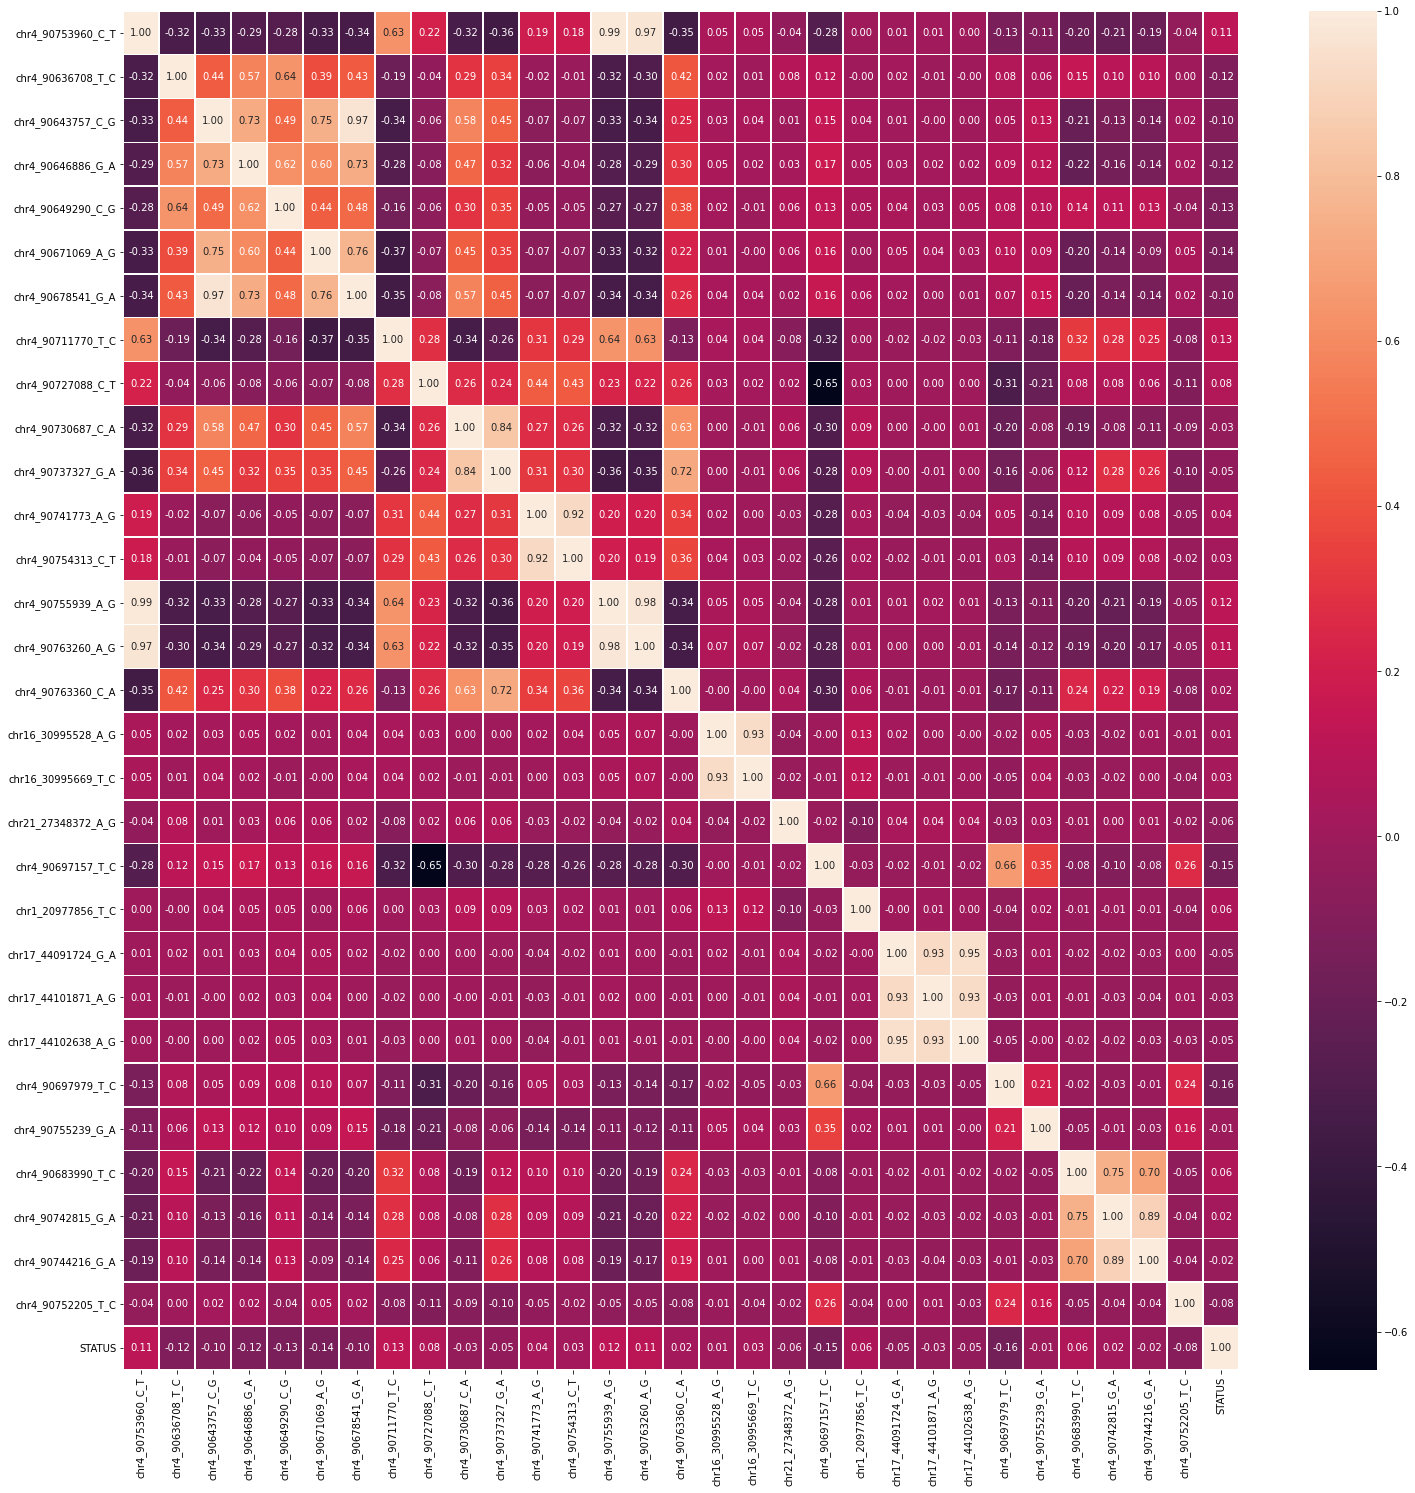

In [ ]:
# Correlation XGBoost

# drop_cols = ['PATNO', 'STATUS'] # Drop cols
# x = df.drop(drop_cols, axis=1) # Axis=1:Cols; Axis=0:Rows

f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(df.corr(),
          annot=True, # Print corr vals
          linewidth=.5,
          fmt='.2f', # Set precison for corr vals
          ax=ax)

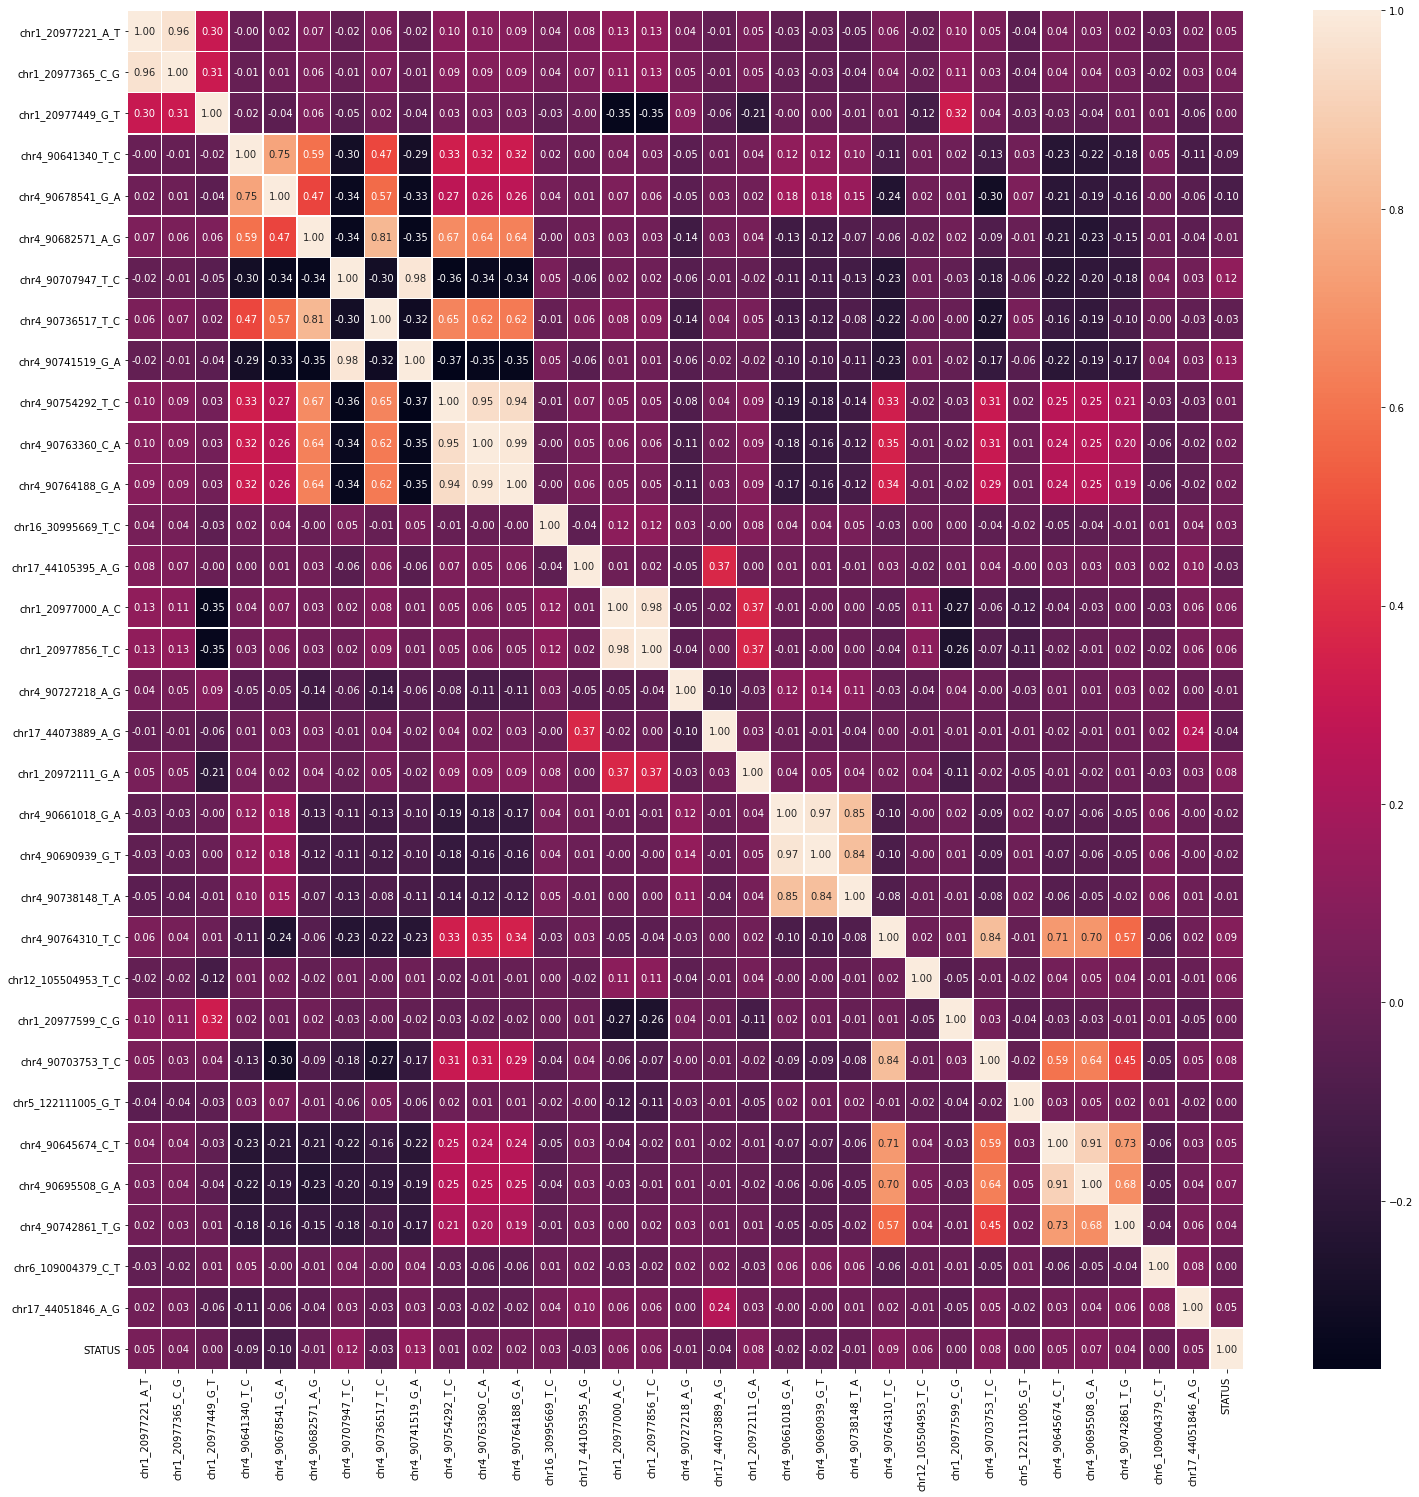

In [ ]:
# Correlation LASSO

# drop_cols = ['PATNO', 'STATUS'] # Drop cols
# x = df.drop(drop_cols, axis=1) # Axis=1:Cols; Axis=0:Rows

f, ax = plt.subplots(figsize=(25,25))
sns.heatmap(df.corr(),
          annot=True, # Print corr vals
          linewidth=.5,
          fmt='.2f', # Set precison for corr vals
          ax=ax)

In [ ]:
print(len(df))
print(len(df.columns))
print(df.columns)

input_columns = len(df.columns)-1
output_columns = 1

733
94
Index(['chr4_90753960_C_T', 'chr1_20977449_G_T', 'chr1_20978058_G_A',
       'chr4_90636708_T_C', 'chr4_90637010_A_G', 'chr4_90637601_G_A',
       'chr4_90641340_T_C', 'chr4_90642464_A_T', 'chr4_90643757_C_G',
       'chr4_90646886_G_A', 'chr4_90649290_C_G', 'chr4_90668419_C_A',
       'chr4_90671069_A_G', 'chr4_90678541_G_A', 'chr4_90682571_A_G',
       'chr4_90703233_A_G', 'chr4_90707947_T_C', 'chr4_90709232_A_T',
       'chr4_90711770_T_C', 'chr4_90721637_C_G', 'chr4_90727088_C_T',
       'chr4_90730687_C_A', 'chr4_90736006_A_C', 'chr4_90736517_T_C',
       'chr4_90737327_G_A', 'chr4_90739539_C_A', 'chr4_90741519_G_A',
       'chr4_90741773_A_G', 'chr4_90743331_C_T', 'chr4_90748195_T_A',
       'chr4_90754313_C_T', 'chr4_90755939_A_G', 'chr4_90757294_A_C',
       'chr4_90757394_G_C', 'chr4_90759047_G_T', 'chr4_90760883_C_T',
       'chr4_90763260_A_G', 'chr4_90763360_C_A', 'chr4_90765052_C_T',
       'chr4_90767095_A_C', 'chr4_90767359_C_T', 'chr4_90767880_T_G',
       'chr16

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

586 147


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

Train Data distribtuion:
PD    410
HC    176
Name: STATUS, dtype: int64


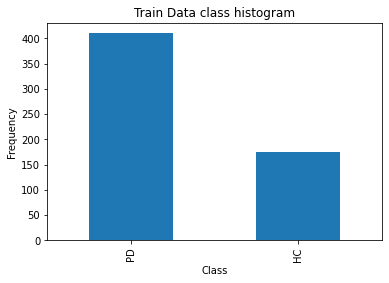

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
PD    106
HC     41
Name: STATUS, dtype: int64


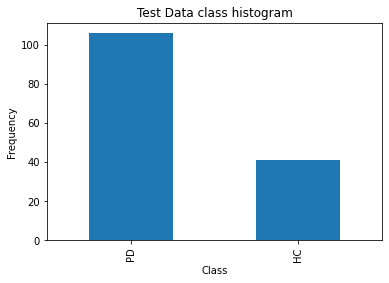

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

# **ML Models - XGBoost**

---



## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.5,0.99,100)


# specify parameters and distributions to sample from
hp = {'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      # 'n_estimators': [10, 25], 
      # 'max_features': [5, 10], 
      # 'max_depth': [10, 50, None], 
      'max_depth': np.arange(1, 15, 1),
      'max_features': [5, 6, 7, 8, 9, 10],
      # 'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      # 'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(10, 200, 10),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'genetic_RF_xgb' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 747 out of 750 | elapsed:  1.6min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.7227272727272727,
                                     1: 0.27727272727272734},
                       criterion='gini', max_depth=2, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True,
 'class_weight': {0: 0.7227272727272727, 1: 0.27727272727272734},
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 6,
 'n_estimators': 170,
 'warm_start': False}

Saving model



AUC-ROC =  0.6219512195121951
AUC-PR =  0.8011906262128917
F1 score =  0.5095541401273885
Precision =  0.7843137254901961
Recall =  0.37735849056603776
              precision    recall  f1-score   support

           0       0.31      0.73      0.44        41
           1       0.78      0.38      0.51       106

    accuracy                           0.48       147
   macro avg       0.55      0.55      0.47       147
weighted avg       0.65      0.48      0.49       147



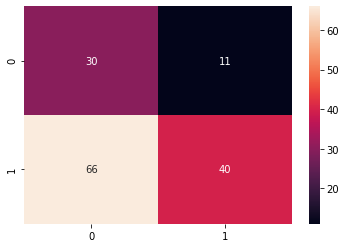

In [ ]:
# load the model from disk
filename = location + 'genetic_RF_xgb' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

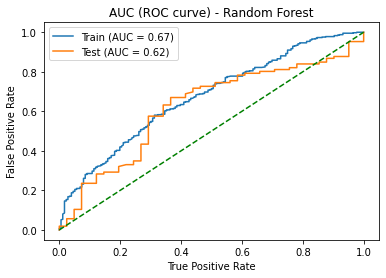

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()
 
# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())
 
# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=50)}
# pprint(hp)
 
# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)
 
#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)
 
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)
 
print("\nSaving model\n")
 
clf = random_search.best_estimator_
 
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)
 
# save the model to disk
filename = location + 'genetic_GNB_xgb' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 50 is smaller than n_iter=200. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s


GaussianNB(priors=None, var_smoothing=1.0)
{'var_smoothing': 1.0}

Saving model



[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.6s finished


AUC-ROC =  0.5965255407271055
AUC-PR =  0.7917843846498747
F1 score =  0.7046632124352331
Precision =  0.7816091954022989
Recall =  0.6415094339622641
              precision    recall  f1-score   support

           0       0.37      0.54      0.44        41
           1       0.78      0.64      0.70       106

    accuracy                           0.61       147
   macro avg       0.57      0.59      0.57       147
weighted avg       0.67      0.61      0.63       147



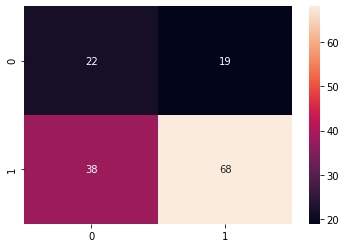

In [ ]:
# load the model from disk
filename = location + 'genetic_GNB_xgb' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

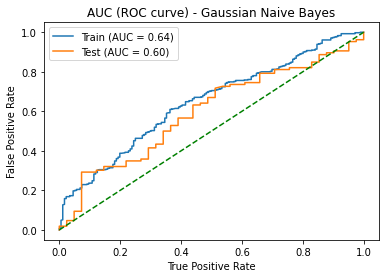

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      # 'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'genetic_SVM_xgb' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 970 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished


SVC(C=10, break_ties=False, cache_size=200,
    class_weight={0: 0.7177777777777777, 1: 0.28222222222222226}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)
{'C': 10,
 'class_weight': {0: 0.7177777777777777, 1: 0.28222222222222226},
 'gamma': 'scale',
 'kernel': 'linear',
 'shrinking': False}

Saving model



AUC-ROC =  0.6264381040036815
AUC-PR =  0.8525192238130244
F1 score =  0.6885245901639345
Precision =  0.8181818181818182
Recall =  0.5943396226415094
              precision    recall  f1-score   support

           0       0.39      0.66      0.49        41
           1       0.82      0.59      0.69       106

    accuracy                           0.61       147
   macro avg       0.60      0.63      0.59       147
weighted avg       0.70      0.61      0.63       147



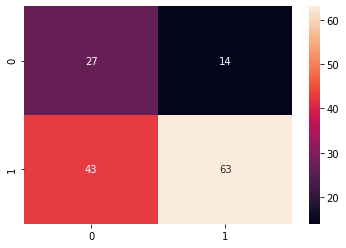

In [ ]:
# load the model from disk
filename = location + 'genetic_SVM_xgb' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=10, break_ties=False, cache_size=200,
    class_weight={0: 0.7177777777777777, 1: 0.28222222222222226}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=0.001, verbose=False)


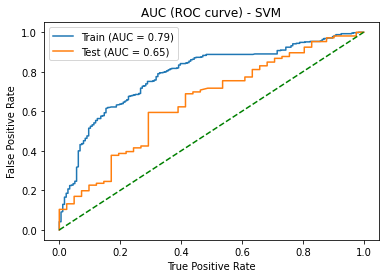

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'genetic_logReg_xgb' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1708 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 2716 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5734 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 7358 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  2.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


LogisticRegression(C=25,
                   class_weight={0: 0.6732323232323232, 1: 0.3267676767676768},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.1, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)
{'C': 25,
 'class_weight': {0: 0.6732323232323232, 1: 0.3267676767676768},
 'l1_ratio': 0.1,
 'multi_class': 'auto',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': False}

Saving model



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


AUC-ROC =  0.6503681546249425
AUC-PR =  0.8266127123414123
F1 score =  0.7150259067357512
Precision =  0.7931034482758621
Recall =  0.6509433962264151
              precision    recall  f1-score   support

           0       0.38      0.56      0.46        41
           1       0.79      0.65      0.72       106

    accuracy                           0.63       147
   macro avg       0.59      0.61      0.59       147
weighted avg       0.68      0.63      0.64       147



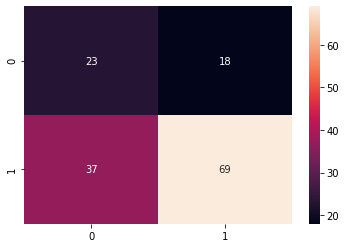

In [ ]:
# load the model from disk
filename = location + 'genetic_logReg_xgb' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=25,
                   class_weight={0: 0.6732323232323232, 1: 0.3267676767676768},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.1, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=81, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)


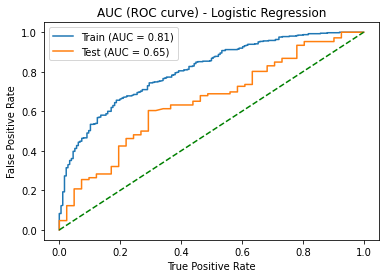

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **Stochastic Gradient Descent**

---

In [ ]:
clf = SGDClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'alpha': [0.0001, 0.001, 0.01, 0.1,0.15,0.2,0.5,0.8,1],
      'l1_ratio': [0,0.1,0.15,0.18,0.2,0.3],
      'loss': ['log'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'random_state': [81],
      'tol': [None]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf, 
                                    param_distributions=hp,
                                    n_iter=n_iter_search, 
                                    cv=StratifiedKFold(),
                                    verbose = 5, 
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'genetic_SGD_xgb_1' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  5.4min finished


SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.7573737373737374, 1: 0.24262626262626263},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)
{'alpha': 0.0001,
 'class_weight': {0: 0.7573737373737374, 1: 0.24262626262626263},
 'l1_ratio': 0.3,
 'loss': 'log',
 'random_state': 81,
 'tol': None}

Saving model



AUC-ROC =  0.6499079613437644
AUC-PR =  0.8260498066012977
F1 score =  0.6553672316384181
Precision =  0.8169014084507042
Recall =  0.5471698113207547
              precision    recall  f1-score   support

           0       0.37      0.68      0.48        41
           1       0.82      0.55      0.66       106

    accuracy                           0.59       147
   macro avg       0.59      0.62      0.57       147
weighted avg       0.69      0.59      0.61       147



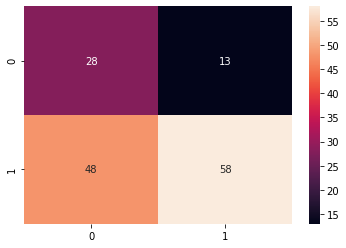

In [ ]:
# load the model from disk
filename = location + 'genetic_SGD_xgb_1' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_SGD = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 0.7573737373737374, 1: 0.24262626262626263},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=81, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)


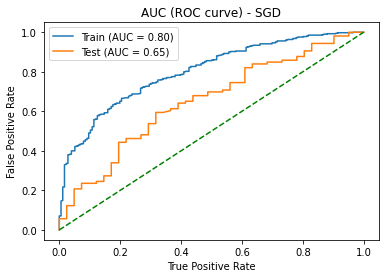

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
  plot_roc_curve(clf, X_list[i], y_list[i], name=name_list[i], ax=ax) 
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SGD")
plt.show()

## **ROC Curve**

---

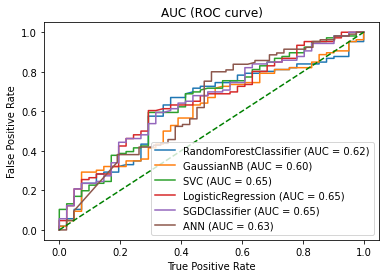

In [ ]:
# XGBoost
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_SGD]

for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)
plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()

# **ANN**

---

In [ ]:
# # Load XGBoost Features
# file = open(location + "feaSel_xgb.txt", "r")
# retain_list = []
# counter = 0
# for line in file:
#   counter +=1
#   if(counter > 0):
#     retain_list.append(line[:-1])

# print(len(retain_list))

93


In [ ]:
# # Retain only XGBoost Features
# retain_list = retain_list[:10]

# all_columns = df.columns
# drop_list = []
# for i in all_columns:
#   if(i not in retain_list and i != "STATUS"):
#     drop_list.append(i)

# df = df.drop(columns = drop_list, axis = 1)
df.head()

,chr4_90753960_C_T,chr4_90649290_C_G,chr4_90671069_A_G,chr4_90678541_G_A,chr4_90711770_T_C,chr4_90741773_A_G,chr4_90754313_C_T,chr16_30995528_A_G,chr1_20977856_T_C,chr4_90697979_T_C,STATUS
0,0,0,0,0,1,1,1,1,0,0,1
1,0,1,1,1,0,1,1,1,0,1,0
2,0,1,1,1,0,1,1,1,1,0,0
3,1,0,0,0,1,1,1,1,0,0,1
4,0,1,1,1,1,1,1,1,1,0,0


In [ ]:
print(len(df))
print(len(df.columns))

input_columns = len(df.columns)-1
output_columns = 1

733
94


#### **Defining Train_data, Val_data and Test data**

---

In [ ]:
dataset = df.values

train_length = int(0.6*len(df))
val_length = int(0.2*len(df))
test_length = int(0.2*len(df))+1

X = dataset[:train_length,0:input_columns]
y = dataset[:train_length, -1].reshape(train_length, 1)

X_valid = dataset[train_length: (train_length + val_length), 0:input_columns]
y_valid = dataset[train_length: (train_length + val_length), -1].reshape(val_length, 1)

X_test = dataset[(train_length + val_length): (train_length + val_length + test_length), 0:input_columns]
y_test = dataset[(train_length + val_length): (train_length + val_length + test_length), -1].reshape(test_length, 1)

# USING CLASS WEIGHTS
class_weights = dict(zip(np.unique(y.flatten()), class_weight.compute_class_weight('balanced', np.unique(y.flatten()), y.flatten())))

scalarX = MinMaxScaler()
scalarX.fit(X)

X = scalarX.transform(X)
X_valid = scalarX.transform(X_valid)
X_test = scalarX.transform(X_test)

print(len(X), len(X_valid), len(X_test))
print(len(X[0]), len(X[0]), len(X_test[0]))

439 146 147
93 93 93


Train Data distribtuion:
PD    305
HC    134
Name: STATUS, dtype: int64


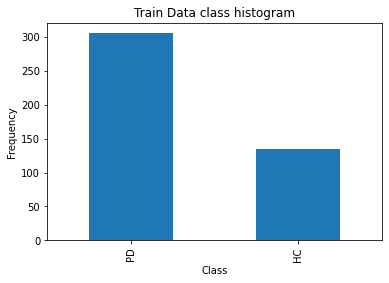

In [ ]:
# Train data distribution
count_classes = df.iloc[:train_length, -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Val Data distribtuion:
PD    105
HC     41
Name: STATUS, dtype: int64


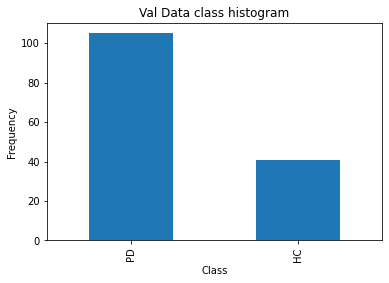

In [ ]:
# Val data distribution
count_classes = df.iloc[train_length: (train_length + val_length), -1].replace({0:"HC", 1:"PD"}).value_counts()
print("Val Data distribtuion:")
print(count_classes)
plt.title("Val Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

Test Data distribtuion:
1    105
0     42
Name: STATUS, dtype: int64


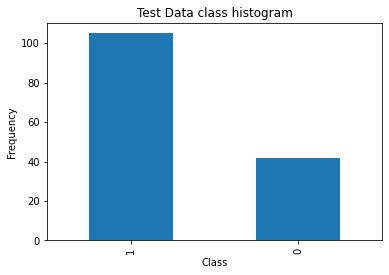

In [ ]:
# Test data distribution
count_classes = df.iloc[(train_length + val_length): (train_length + val_length + test_length), -1].value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency") 
count_classes.plot(kind = 'bar')

# **Training the Model**

---

In [ ]:
model = Sequential()
model.add(Dense(2, input_dim=input_columns, activation='relu'))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dense(16, activation = 'relu'))
# model.add(Dense(8, activation = 'relu'))
model.add(Dense(output_columns, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 188       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 5
num_epoch = 50
output = model.fit(X, y, batch_size = batch_size, epochs=num_epoch, verbose=1,
                   class_weight=class_weights, validation_data=(X_valid, y_valid))

Epoch 1/50
88/88 [==============================] - 1s 4ms/step - loss: 0.6988 - val_loss: 0.7057
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6903 - val_loss: 0.7036
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6879 - val_loss: 0.6986
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6954 - val_loss: 0.7014
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.7007 - val_loss: 0.6976
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 0.7027 - val_loss: 0.6982
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 0.7180 - val_loss: 0.6988
Epoch 8/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6887 - val_loss: 0.6986
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6904 - val_loss: 0.6964
Epoch 10/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6819 - val_loss: 0.7056
Epoch 11/50
88/88 [

<Figure size 432x288 with 0 Axes>

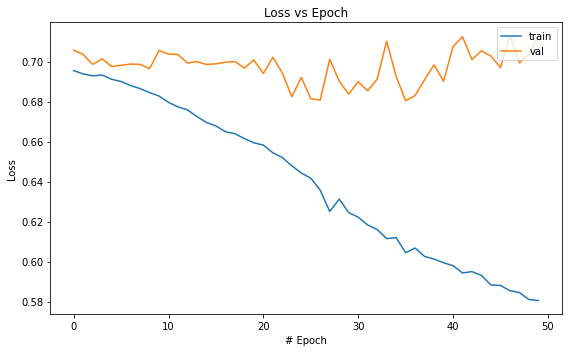

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()

### **Save Model**

In [ ]:
# Saving the model
print("\nSaving model")
# serialize model to JSON
model_json = model.to_json()
with open(location + "genetic_ann_xgb.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model as json")
# serialize weights to HDF5
model.save_weights(location + "genetic_ann_xgb_wt.h5")
print("Saved model weights")


Saving model
Saved model as json
Saved model weights


# **Model Evaluation**

---

Train AUC-ROC = 0.78
Validation AUC-ROC = 0.56
Test AUC-ROC = 0.63


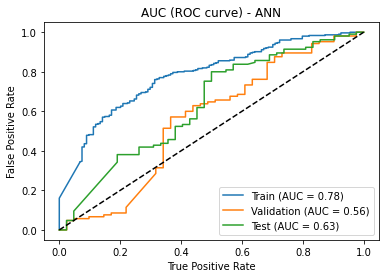

In [ ]:
pred = model.predict(X)
# train_y_pred = np.where(pred > 0.5, 1, 0)
fpr_train, tpr_train, _ = roc_curve(y, pred)
auc_train = auc(fpr_train, tpr_train).round(2)
print("Train AUC-ROC =", str(auc_train))

pred = model.predict(X_valid)
# val_y_pred = np.where(pred > 0.5, 1, 0)
fpr_val, tpr_val, _ = roc_curve(y_valid, pred)
auc_val = auc(fpr_val, tpr_val).round(2)
print("Validation AUC-ROC =", str(auc_val))

pred = model.predict(X_test)
# test_y_pred = np.where(pred > 0.5, 1, 0)
fpr_test, tpr_test, _ = roc_curve(y_test, pred)
auc_test = auc(fpr_test, tpr_test).round(2)
print("Test AUC-ROC =", str(auc_test))

plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_val, tpr_val, label='Validation (AUC = {:.2f})'.format(auc_val))
plt.plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - ANN")
plt.show()

In [ ]:
def check_metrics(model, testX, testY):  

  pred = model.predict(testX)
  y_pred = np.where(pred > 0.5, 1, 0)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(testY, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  print(classification_report(testY, y_pred))

In [ ]:
check_metrics(model, X_test, y_test)

##############  Confusion Matrix  ##############

[[24 18]
 [48 57]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

           0       0.33      0.57      0.42        42
           1       0.76      0.54      0.63       105

    accuracy                           0.55       147
   macro avg       0.55      0.56      0.53       147
weighted avg       0.64      0.55      0.57       147



In [ ]:
check_metrics(model, X_valid, y_valid)

##############  Confusion Matrix  ##############

[[24 17]
 [45 60]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

           0       0.35      0.59      0.44        41
           1       0.78      0.57      0.66       105

    accuracy                           0.58       146
   macro avg       0.56      0.58      0.55       146
weighted avg       0.66      0.58      0.60       146



In [ ]:
check_metrics(model, X, y)

##############  Confusion Matrix  ##############

[[106  28]
 [113 192]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

           0       0.48      0.79      0.60       134
           1       0.87      0.63      0.73       305

    accuracy                           0.68       439
   macro avg       0.68      0.71      0.67       439
weighted avg       0.75      0.68      0.69       439



# **Checking Correlations**

---

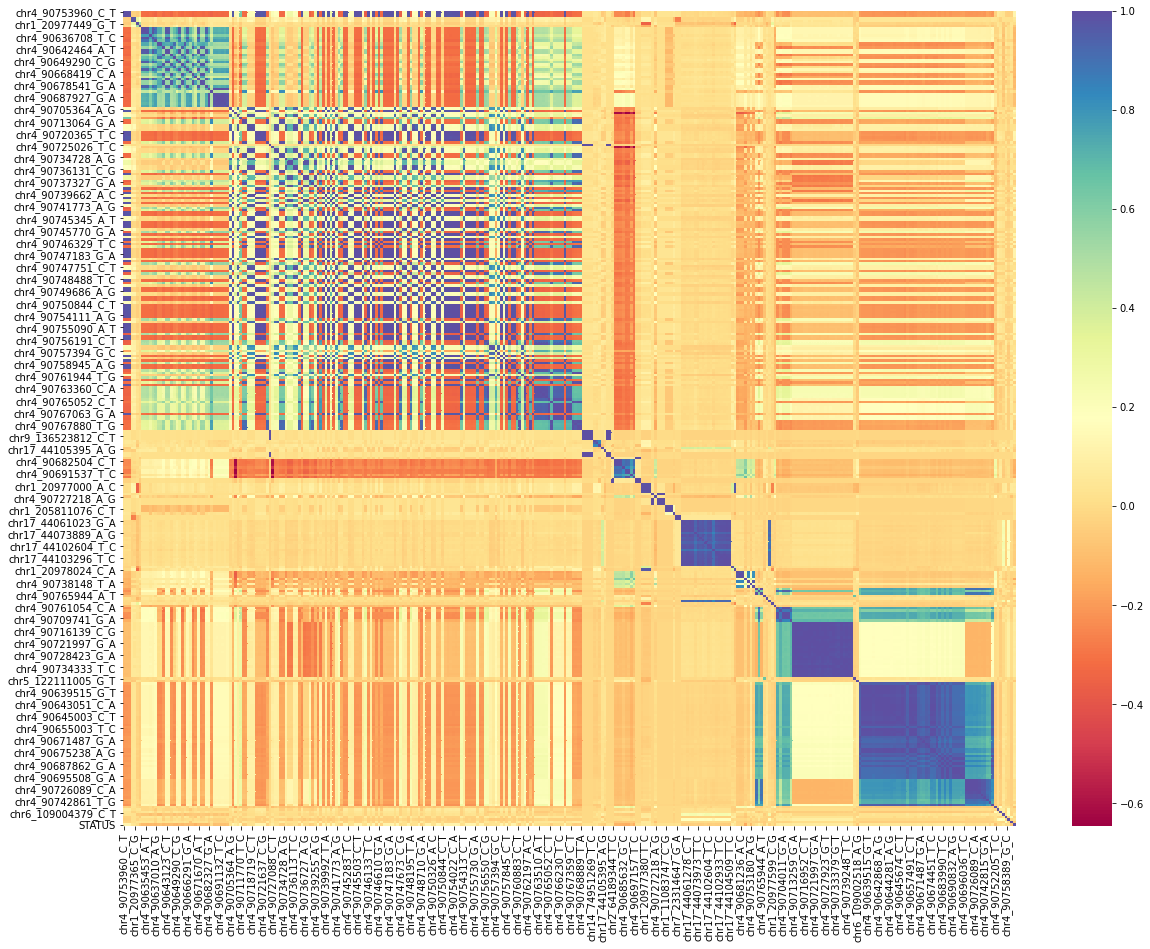

In [ ]:
plt.figure(figsize=(20,15))
cor = df.corr()
sns.heatmap(cor, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
print("IMPORTANT FEATURES")
print()
imp_features_list = []
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1) > 0.1 or abs(corr2) > 0.1 ):
      imp_features_list.append(df.columns[i])
      # print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
# print()

print("REDUNDANT FEATURES")
print()
for i in range(input_columns):
    corr1, _ = spearmanr(X[:,i], y[:, 0])
    corr2, _ = pearsonr(X[:,i], y[:, 0])
    if(abs(corr1)< 0.01 or abs(corr2) < 0.01 ):
      pass
        # print(df.columns[i]+":\t\t",'Spearmans correlation: %.3f' % abs(corr1), 'Pearsons correlation: %.3f' % abs(corr2) )
# print()

IMPORTANT FEATURES

REDUNDANT FEATURES

